# PyWeather
## Import and Setup

In [2]:
# Import dependencies
%matplotlib inline
import gmaps
import matplotlib.pyplot as plt
import pandas as pd
import random
from citipy import citipy as cp
from IPython.display import display, HTML

import config
import auth

errors = []
if auth.owm_api_key == '':
    errors.append('ERROR! Openweathermap API key is not configured. Open \'auth.py\' file and set up your API key')
if auth.gmaps_api_key == '':
    errors.append('ERROR! Google Maps API key is not configured. Open \'auth.py\' file and set up your API key')

if len(errors) > 0:
    error_message = '\\n'.join(errors)
    js = f'<script>alert("{error_message}");</script>'
    display(HTML(js))
    exit()
else:
    print('All API keys are configured')
    gmaps.configure(api_key=auth.gmaps_api_key)

All API keys are configured


## Pick Random Cities

Our goal here is to randomly pick N cities so that their locations should be evenly distributed across the whole range of latitudes. While technically we could just use a range of -90 to 90, take N random points from this range and get nearest citieis, there are risks in taking too many values from the range where no cities are located and we could end up taking the closest cities that will be densed across several points.

Instead I will use the following algorithm:
1. Take all cities with their coordinates from `citipy` library and sort them by latitude
2. Take the min and max available latitudes (so we won't bother with the northern and the sourthern poles and their vicinities)
3. Split the available latitude range into N subranges
4. For each subrange pick a random city that has its latitude belong to this subrange

This way our cities will be distrubuted evenly along the latitude range (and we have good chances to have them spread across the longitude range even though for this research it doesn't matter that much)

There is one caveat though. For some intervals there may not be found even a single city. In this case we skip this interval and will later try to pick the remaining count from the general pool

In [3]:
# 1. Sort all the citieis by latitude
all_cities = sorted(cp.WORLD_CITIES_DICT.items(), key=(lambda x: x[0]))
# Lets print first 10 values (the City object from citipy package contain city name, country code and coordinates)
print(f'There are {len(all_cities)} cities in total')
print('Here are the first ten:')
sample_cities = [
    f'{city[1].city_name.title()}, {city[1].country_code.upper()} at ({city[0][0], city[0][1]})' 
    for city in all_cities[:10]
]
sample_cities

There are 46723 cities in total
Here are the first ten:


['Ushuaia, AR at ((-54.8, -68.3))',
 'Punta Arenas, CL at ((-53.15, -70.916667))',
 'Rio Gallegos, AR at ((-51.622613, -69.218127))',
 'Bluff, NZ at ((-46.6, 168.333333))',
 'Invercargill, NZ at ((-46.4, 168.35))',
 'Riverton, NZ at ((-46.35, 168.016667))',
 'Wallacetown, NZ at ((-46.333333, 168.266667))',
 'Wyndham, NZ at ((-46.333333, 168.85))',
 'Edendale, NZ at ((-46.316667, 168.783333))',
 'Kaitangata, NZ at ((-46.275, 169.85))']

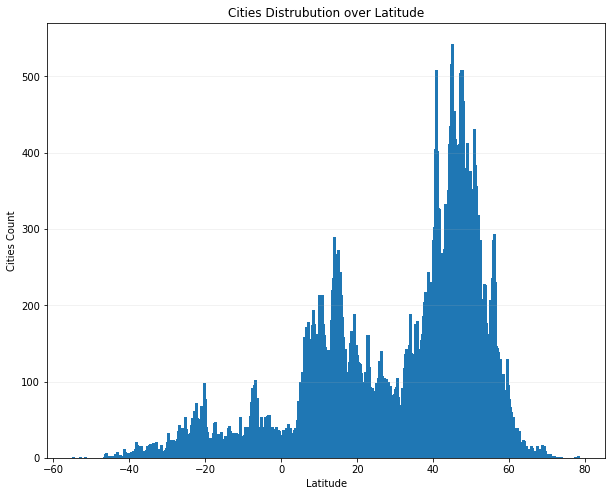

In [4]:
# 2. Pick min and max latitudes to identify the available range
min_latitude = all_cities[0][0][0]
max_latitude = all_cities[-1][0][0]
latitude_range = max_latitude - min_latitude
# 3. Split the latitude range into N subranges
latitude_step = latitude_range / config.cities_count
latitude_buckets = [min_latitude + (i + 1) * latitude_step for i in range(config.cities_count)]
city_buckets = []
current_max_lat = 0
current_bucket = []
i = 0
while i < len(all_cities):
    city = all_cities[i]
    city_latitude = city[0][0]
    # If current city falls into the latitude range we add it to the current bucket and proceed to the next one
    if city_latitude <= latitude_buckets[current_max_lat]:
        current_bucket.append(city)
        i += 1
    # Otherwise we saves our current bucket into the bucket list, create new bucket
    #  and proced to the next latitude range (so we can re-check the same city against next latitude range)
    else:
        current_max_lat += 1
        city_buckets.append(current_bucket)
        current_bucket = []
city_buckets.append(current_bucket)
# Lets build a simple chart to see how those cities are distributed over the latitude range
plt.figure(figsize=(10, 8))
plt.bar(latitude_buckets, [len(cities) for cities in city_buckets])
plt.title('Cities Distrubution over Latitude')
plt.xlabel('Latitude')
plt.ylabel('Cities Count')
plt.grid(alpha=0.2, axis='y')
plt.show()

In [5]:
# 4. Pick random cities from these ranges
# Some buckets may contain no cities at all thus we can't pick one from them
# So first we pick from those we can
picked_cities = []
for city_bucket in city_buckets:
    if len(city_bucket) > 0:
        city_index = random.randrange(len(city_bucket))
        # Here we remove picked city so it won't be picked again during the second stage
        city = city_bucket.pop(city_index)
        picked_cities.append(city)

# Now we take all remaining citites and pick (N - picked cities count) cities
remaining_cities = [city for cities in city_buckets if len(cities) > 0 for city in cities]
picked_cities = picked_cities + random.choices(remaining_cities, k=config.cities_count - len(picked_cities))
# Here are the ten random cities from the middle of the list
sample_cities = [
    f'{city[1].city_name.title()}, {city[1].country_code.upper()} at ({city[0][0], city[0][1]})' 
    for city in picked_cities[config.cities_count // 2:config.cities_count // 2 + 10]
]
sample_cities

['Atlatlahucan, MX at ((18.933333, -98.9))',
 'Villa De Alvarez, MX at ((19.25, -103.733333))',
 'Tepetitlan, MX at ((19.633333, -99.916667))',
 'Cotija, MX at ((19.816667, -102.683333))',
 'Tessalit, ML at ((20.2013889, 1.0088889))',
 'Zacoalco, MX at ((20.233333, -103.583333))',
 'Opichen, MX at ((20.55, -89.85))',
 'Merida, MX at ((20.966667, -89.616667))',
 'Nagpur, IN at ((21.15, 79.1))',
 'Ewa Beach, US at ((21.3155556, -158.0072222))']

In [7]:
# Now lets show our pick of cities on Google maps
fig = gmaps.figure(zoom_level=1, center=(0,0))
locations = [city[0] for city in picked_cities]
info_box_template = '''
<dl>
<dt>City</dt><dd>{city}</dd>
<dt>Country</dt><dd>{country}</dd>
<dt>Location</dt><dd>{location}</dd>
</dl>
'''
info = [info_box_template.format(**{ 
    'city': city[1].city_name.title(),
    'country': city[1].country_code.upper(),
    'location': city[0]
}) for city in picked_cities]
cities_layer = gmaps.symbol_layer(locations, fill_color='red', scale=2, info_box_content=info)
fig.add_layer(cities_layer)
fig

Figure(layout=FigureLayout(height='420px'))